# Question 2

In this question we will:
- Implement the vector median filter for colour images.
- Apply the vector median filter to a small dataset and establish a baseline performance meteric.
- Try to design a denoising pipeline that outperforms using only the vector median filter.   

# Step 1: Implement the vector median filter for colour images.

## Instructions

- Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes and implementation suggestions can be found in Section 2 of the asignment PDF.  
- The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.
- Your function should accept images of dtype `uint8` or `float64` (other types may be rejected if you wish).    It is easiest if you work with the image as data type `float64`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float64`, construct the output image also as type `float64` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [3]:
def vector_median(I, radius):
    # only accept images of dtype uint8 or float64
    if I.dtype != np.uint8 and I.dtype != np.float64:
        return None

    # track if input image is uint8 and convert it to float64
    is_int_type = False
    if I.dtype == np.uint8:
        is_int_type = True
        I = skutil.img_as_float64(I)

    # calculate appropriate window size
    window_size = radius * 2 + 1

    # get the number of rows and columns and calculate half the window size
    rows, columns, _ = I.shape
    half_window = window_size // 2

    # pad the image with pixels that match the edge colors
    I_padded = np.pad(I, ((half_window, half_window), (half_window, half_window), (0, 0)), mode="edge")

    # to store the result
    result = np.zeros(I.shape, dtype=I.dtype)

    # for each pixel in the original image
    for row in range(half_window, rows+half_window):
        for col in range(half_window, columns+half_window):
            # create a matrix of the color vectors of all the pixels in the neighborhood
            window = I_padded[row-half_window:row+half_window+1, col-half_window:col+half_window+1, :]

            # flatten it to (n x 3) where n is window_size**2
            colours = np.reshape(window, [window.shape[0] * window.shape[1], 3])

            # tile it 
            Y = np.tile(colours, (window.shape[0] * window.shape[1], 1, 1))

            X = np.tile(colours[:, np.newaxis, :], (1, window.shape[0] * window.shape[1], 1))

            # # compute the absolute difference of the two matrices
            D = np.sum(np.sum(np.abs(X - Y), axis=2), axis=1)

            # place the correct pixels in the resulting image
            result[row-half_window, col-(half_window+1)] = colours[np.argmin(D)]
            
    # convert result back to uint8 if necessary        
    if is_int_type:
        result = skutil.img_as_ubyte(result)

    return result

# Step 2a: Establish a Baseline

## Instructions

- Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list.  
    - Use the same method to read the images files as in question 1, but read them from the `images/noisy` directory and the `images/noiseless` directory as needed.
- Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.   
    - As with question 1, to save time we recommend you develop and debug your programs using only the first three to five images in file_list, and run it on the complete list when you're done. 
- The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skmetrics.peak_signal_noise_ratio()` and `skmetrics.structural_similarity()`.  You'll need the `channel_axis=2` argument for `structural_similarity()`.  This indicates to the function that the it is the 3rd dimension of the 3D arrays that index the R, G and B channels.

_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._



In [4]:
# Some modules you might need.

import skimage.io as io
import os as os
import skimage.filters as skfilt
import skimage.metrics as skmetrics
import skimage.util as skutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Use pandas to read the image filenames and then create a list of the filenames called file_list, just like you did in question 1.
files = pd.read_csv("images.csv", header=None)

file_list = files[0].tolist()

# print(file_list)

noisy_dir = "/images/noisy/"
noiseless_dir = "/images/noiseless/"

psnr_before = []
psnr_after = []
ssim_before = []
ssim_after = []

for filename in file_list:   # you can restrict this to, for example,  file_list[0:3], for testing
#     Process the noisy image file here.  The images have the same filenames name in the 
#     noisy, noisy-test, and noiseless folders.  You'll have to construct the paths to these
#     images yourself.  This is easy to do using using os.path.join().
    noisy_img = skutil.img_as_float(io.imread(os.getcwd() + noisy_dir + filename))
    denoised_img = vector_median(noisy_img, 1)

    noiseless_img = skutil.img_as_float(io.imread(os.getcwd() + noiseless_dir + filename))

    psnr_before.append(skmetrics.peak_signal_noise_ratio(noiseless_img, noisy_img))
    psnr_after.append(skmetrics.peak_signal_noise_ratio(noiseless_img, denoised_img))
    ssim_before.append(skmetrics.structural_similarity(noiseless_img, noisy_img, data_range=1.0, channel_axis=2))
    ssim_after.append(skmetrics.structural_similarity(noiseless_img, denoised_img, data_range=1.0, channel_axis=2))





# Step 2b: Compute average baseline metrics.

## Instructions

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

<BarContainer object of 2 artists>

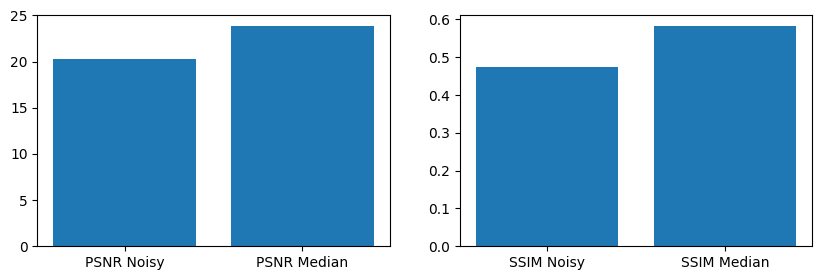

In [5]:
# some modules you might need.

import matplotlib.pyplot as plt
import numpy as np

psnr = [np.mean(psnr_before), np.mean(psnr_after)]
ssim = [np.mean(ssim_before), np.mean(ssim_after)]


plt.subplots(1, 2, figsize=(10, 3))

plt.subplot(1, 2, 1)
x_labels = ["PSNR Noisy", "PSNR Median"]
plt.bar(x_labels, psnr)


plt.subplot(1, 2, 2)
x_labels = ["SSIM Noisy", "SSIM Median"]
plt.bar(x_labels, ssim)


# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


In [10]:
import skimage.restoration as skrest

# Write your de-noising method here.
def denoise(image):
    var = 0.003
    sigma = 0.0548

    image_f64 = skutil.img_as_float(image)
    nlm_denoise = skrest.denoise_nl_means(image_f64, h=0.8*sigma, sigma=sigma, patch_size=5, patch_distance=6, fast_mode=True)
    vmf_denoise = vector_median(nlm_denoise, 1)

    return vmf_denoise

In [11]:
noisy_dir = "/images/noisy/"
noiseless_dir = "/images/noiseless/"

my_psnr = []
my_ssim = []

for filename in file_list:
    print(filename)
    noisy_img = skutil.img_as_float(io.imread(os.getcwd() + noisy_dir + filename))
    denoised_img = denoise(noisy_img)

    noiseless_img = skutil.img_as_float(io.imread(os.getcwd() + noiseless_dir + filename))

    my_psnr.append(skmetrics.peak_signal_noise_ratio(noiseless_img, denoised_img))
    my_ssim.append(skmetrics.structural_similarity(noiseless_img, denoised_img, data_range=1.0, channel_axis=2))


100075.png
100080.png
100098.png
103041.png
104022.png
105019.png
105053.png
106020.png
106025.png
108041.png
108073.png
109034.png
112082.png
113009.png
113016.png
113044.png
117054.png
118020.png
118035.png
12003.png
12074.png
122048.png
124084.png
126039.png
130034.png
134008.png
134052.png
135037.png
135069.png
138032.png
138078.png
140055.png
140075.png
144067.png
145014.png
145053.png
147021.png
147062.png
15004.png
15088.png
151087.png
153077.png
153093.png
155060.png
156079.png
157036.png
159029.png
159045.png
159091.png
16052.png
161062.png
163014.png
163062.png
164074.png
166081.png
169012.png
170054.png
172032.png
173036.png
176019.png
176035.png
176039.png
178054.png
181018.png
181079.png
181091.png
183055.png
183087.png
187003.png
187029.png
187039.png
187071.png
187083.png
188005.png
188063.png
188091.png
189003.png
189011.png
196015.png
198004.png
198023.png
198054.png
20008.png
202012.png
207056.png
209070.png
2092.png
216041.png
216053.png
216066.png
22013.png
22090.pn

<BarContainer object of 3 artists>

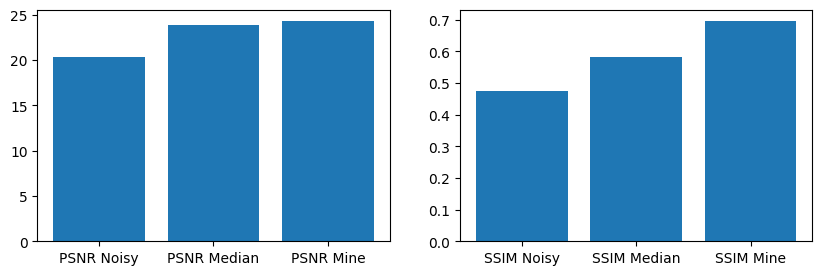

In [14]:
new_psnr = psnr.copy()
new_ssim = ssim.copy()

new_psnr.append(np.mean(my_psnr))
new_ssim.append(np.mean(my_ssim))


plt.subplots(1, 2, figsize=(10, 3))

plt.subplot(1, 2, 1)
x_labels = ["PSNR Noisy", "PSNR Median", "PSNR Mine"]
plt.bar(x_labels, new_psnr)


plt.subplot(1, 2, 2)
x_labels = ["SSIM Noisy", "SSIM Median", "SSIM Mine"]
plt.bar(x_labels, new_ssim)